# Text-Processing with R (EM Clustering)

### Developer: Mayana Mohsin Khan

Install the following libraries to run the notebook,

In [2]:
#install.packages('tm')
#install.packages('SnowballC')

**Loading Libraries**

In [3]:
library(tm) # Loading text mining package
library(SnowballC) # Loading snowball C package

Warning message:
"package 'tm' was built under R version 3.6.3"Loading required package: NLP
Warning message:
"package 'SnowballC' was built under R version 3.6.3"

**Reading Data and Text Pre-processing**

In this stem, we read the data and preform some basic text pre-processing on the text data provided.

**Text Preporcessing steps:**
- Remove stopwords.
- Remove Punctuaions
- Stemming
- Remove numeric words
- strip splaces
- sentences to tokens

Create a matrix for storing the document and words/tokens.
For Example:

|document/words| words | words | words |
| --- | --- | --- | --- |
| 1 | This | is | example| 
| 2 | Sentence | in | document | 

In [4]:
eps=1e-10 # Setting a randowm value eps 
  
# function to read the data
read.data <- function(file.name, sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
    
    # Read the data
    text <- readLines(file.name)
    
    # select a subset of data if sample.size > 0
    if (sample.size>0){
        set.seed(seed)
        text <- text[sample(length(text), sample.size)]
    }
    
    ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
    docs <- strsplit(text, '\t')
    
    # store the labels for evaluation
    labels <-  unlist(lapply(docs, function(x) x[1]))
                             
    # store the unlabeled texts    
    docs <- data.frame(doc_id=1:length(docs), text=unlist(lapply(docs, function(x) x[2])))  
    
    # create a corpus
    docs <- DataframeSource(docs)
    corp <- Corpus(docs)
                                                                 
    # Text Pre-processing:
    if (pre.proc){
        corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
        corp <- tm_map(corp, removePunctuation) # remove pnctuation
        corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
        corp <- tm_map(corp, removeNumbers) # remove all numbers
        corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
    }  
                                                                 
    # Create a matrix which its rows are the documents and colomns are the words. 
    dtm <- DocumentTermMatrix(corp)
    ## reduce the sparcity of out dtm
    dtm <- removeSparseTerms(dtm, spr.ratio)
    ## convert dtm to a matrix
    word.doc.mat <- t(as.matrix(dtm))

    # Return the result
    return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))                                                                                                                        
}

## II. Implement the hard-EM and soft-EM 
Chapter 5 of Module 4). Please provide enough comments in your
submitted code.

**Axulliary Function**
#### The Log function: 
We are using the log function 
 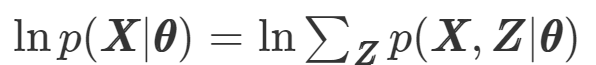

In [5]:
## Log likelyhood function
logSum <- function(v) {
    m = max(v)
    return ( m + log(sum(exp(v-m))))
}

**Initialize the Model Parameter**

We need to initialize the model parameter'
- rho
- mu

In [6]:
## Initialize model parameters randomly 
initial.param <- function(vocab_size, K=4, seed=123456){
    set.seed(seed) 
    rho <- matrix(1/K,nrow = K, ncol=1)            # assume all clusters have the same size (we will update this later on)
    mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
    mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
    return (list("rho" = rho, "mu"= mu))
}

**E Step**

In the E Step, we find the probablity of word in cluster k
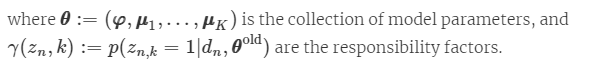

In [7]:
## E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the soft-EM
# Student needs to modify this function if wants to make it Hard-EM 

E.step <- function(gamma, model, counts){
    # Model Parameter Setting
    N <- dim(counts)[2] # number of documents
    K <- dim(model$mu)[1]
    # E step:    
    for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
    }

    # converting back from the log space
    gamma <- exp(gamma)
    return (gamma)
}

**M Step**

In the M step we need to find the values for `rho` and `mu`.
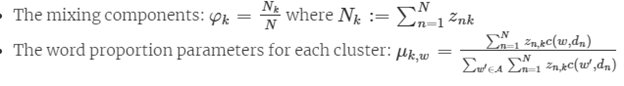

In [8]:
##--- M Step for Document Clustering  --------------------------------------------
M.step <- function(gamma, model, counts){
    # Model Parameter Setting
    N <- dim(counts)[2]   # number of documents
    W <- dim(counts)[1]   # number of words i.e. vocabulary size
    K <- dim(model$mu)[1] # number of clusters

    # M step: Student needs to write this part for soft/hard EM
    #......
    #
    # hint: before you normalise a vector so that it sums to 1, first add a small number (eps) to all elements of the vector.
    # for example, suppose you have a vector [n1,n2,n3] and you want to normalise it to make it a probability distribution. 
    # you first need to add eps to elements [n1+eps,n2+eps,n3+eps], then divide the elements by (n1+n2+n3+ 3*eps) so that the vecotr sums to 1. 
    # this prevents NaN for vectors where all elements aer zero such as [0,0,0] because after adding eps you have [eps,eps,eps] which 
    # results in the uniform distribution after normalisation.  
    
    # loop for M step
    for(k in 1:K){
        N.k <- sum(gamma[,k]) # get the vale of Nk
        model$rho[k] <- N.k/N  # get the value of rho
        for(w in 1:W){
            model$mu[k,w] <- t(gamma[,k]) %*% as.matrix(counts[w,])+eps # get the value of mu
        }
        p <- sum(model$mu[k,]) # sum of all mu for a cluster
        for(w in 1:W){
             model$mu[k,w] <- (model$mu[k,w]/p)+N*eps # update the value of mu
        }
    }
    # Return the result
    return (model)
}

**EM Step**

In the EM step, we run a loop to get the E and M steps for the EM Algorithm in multiple epochs.
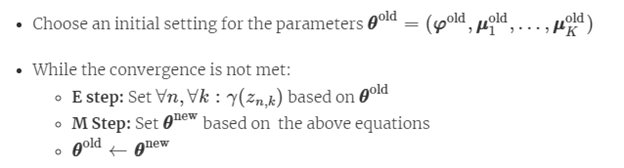

In [9]:
##--- EM for Document Clustering --------------------------------------------
EM <- function(type = 'soft' ,counts, K=4, max.epoch=10, seed=123456){
    #INPUTS:
    ## counts: word count matrix
    ## K: the number of clusters
    #OUTPUTS:
    ## model: a list of model parameters

    # Model Parameter Setting
    N <- dim(counts)[2] # number of documents
    W <- dim(counts)[1] # number of unique words (in all documents)

    # Initialization
    model <- initial.param(W, K=K, seed=seed)
    gamma <- matrix(0, nrow = N, ncol = K)

#     print(train_obj(model,counts))
    # Build the model
    for(epoch in 1:max.epoch){
        
        if(type == 'soft'){
            # E Step
            # For soft EM
            gamma <- E.step(gamma, model, counts)
            # M Step
            model <- M.step(gamma, model, counts)
        } else {
            # E Step
            # For hard EM
            gamma <- E.step(gamma, model, counts)
            for (n in 1:N) {
                clus <- which.max(gamma[n,])
                gamma[n,] <- 0
                gamma[n,clus] <- 1
            }
            # M Step
            model <- M.step(gamma, model, counts)
    }
#     print(train_obj(model,counts)) 
    }
    # Return Model
    return(list("model"=model,"gamma"=gamma))
}

#### Training Objective

In Training objective function, we get the Maximum log likelihood.

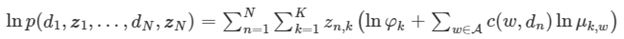

In [10]:
##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 

train_obj <- function(model, counts) { 
    N <- dim(counts)[2] # number of documents
    K <- dim(model$mu)[1]

    nloglike = 0
    for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
    }

    return (nloglike)
}

#### Cluster Visualization

In [11]:
##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
    p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
    plot(p.comp$x, col=color.vector, pch=1,  main=title)
}


## III & IV

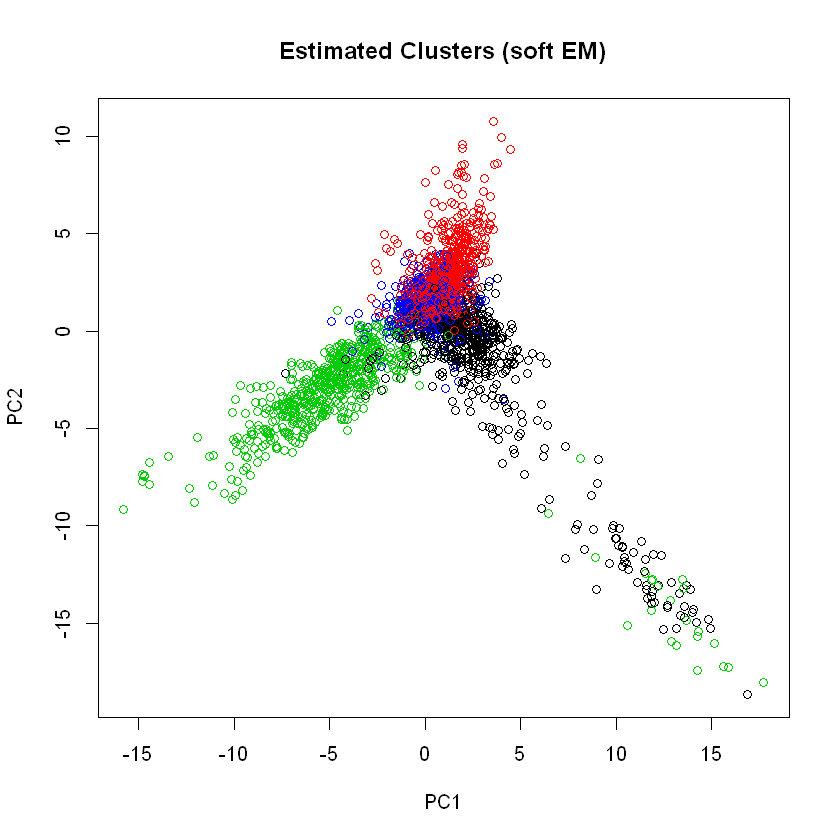

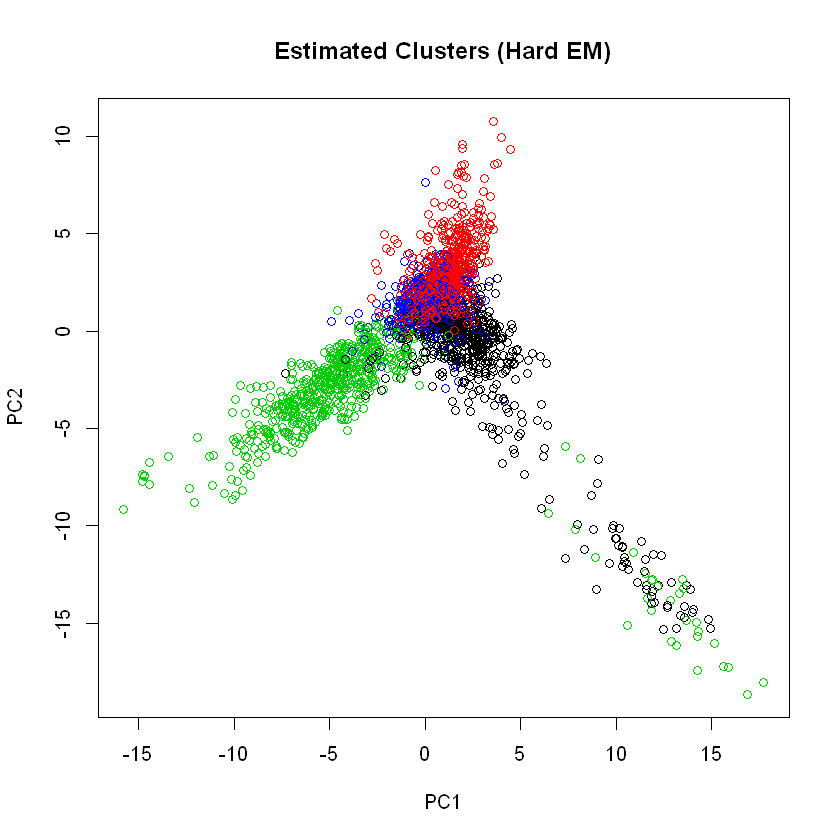

In [12]:
### main body ##################################################################
# Reading documents 
## Note: sample.size=0 means all read all documents!
# read the data
data <- read.data(file.name='Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        

# calling the EM algorithm on the data
res.soft <- EM('soft',counts, K=4, max.epoch=5) # Soft
res.hard <- EM('hard',counts, K=4, max.epoch=5) # Hard

# visualization
## find the culster with the maximum probability 
label.hat.soft <- apply(res.soft$gamma, 1, which.max) # Soft
label.hat.hard <- apply(res.hard$gamma, 1, which.max) # hard

## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

## visualize the estimated clusters
cluster.viz(t(counts), label.hat.soft, 'Estimated Clusters (soft EM)') # Soft
cluster.viz(t(counts), label.hat.hard, 'Estimated Clusters (Hard EM)') # Hard

## Conclusion 

### Soft VS Hard

From the two graphs, we can see that for soft vs hard clusters, the clusters overlap more for soft compared to hard, i.e. upon closer examination certain pints from the grees cluster over lap and ae assigned to red cluster in soft EM while they remain into green clusers in Hard EM.